# Projeto de Engenharia do Conhecimento 2023/2024

*Projeto by: Renato Ferreira (58238), Pedro (), Simão Quintas (58190)*

### Index

1. Feature selection
    1. Using correlation
    2. Using stepwise methods
    3. Random Forests for Feature Selection
2. Principal Components analysis
    1. Linear PCA
    2. Kernel PCA
3. Model Tuning


## 1. Feature selection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

Start the imputer and get the data

In [12]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")

data = pd.read_csv('proj-data.csv', na_values='?')
print(data.columns)

Index(['age:', 'sex:', 'on thyroxine:', 'query on thyroxine:',
       'on antithyroid medication:', 'sick:', 'pregnant:', 'thyroid surgery:',
       'I131 treatment:', 'query hypothyroid:', 'query hyperthyroid:',
       'lithium:', 'goitre:', 'tumor:', 'hypopituitary:', 'psych:',
       'TSH measured:', 'TSH:', 'T3 measured:', 'T3:', 'TT4 measured:', 'TT4:',
       'T4U measured:', 'T4U:', 'FTI measured:', 'FTI:', 'TBG measured:',
       'TBG:', 'referral source:', 'diagnoses', '[record identification]'],
      dtype='object')


Let's drop the rows and columns with a large number of NA values and get dummies for the columns with strings

In [13]:
# Remover as linhas com pouca informação
data.dropna(thresh=3, subset=['T3 measured:', 'TT4 measured:', 'T4U measured:', 'FTI measured:', 'TBG measured:'], inplace=True)

# Remover as colunas com pouca informação
data.dropna(axis=1, thresh=3669, inplace=True)

# Remover as colunas que indicam se algo foi medido ou não e a que tem a indentificação
columns_to_drop = data.filter(like='measured').columns
data.drop(columns_to_drop, axis=1, inplace=True)
data.drop('[record identification]', axis=1, inplace=True)

# Remover linhas com homens grávidos
data = data[~((data['sex:'] == 'M') & (data['pregnant:'] == "t"))]

In [14]:
def transform_diagnoses(df):

    hyperthyroid_conditions = ['A', 'B', 'C', 'D']
    hypothyroid_conditions = ['E', 'F', 'G', 'H']
    binding_protein = ['I', 'J']
    general_health = ['K']
    replacement_therapy = ['L', 'M', 'N']
    antithyroid_treatment = ['O', 'P', 'Q']
    other = ['R', 'S', 'T']
    none = ['-']

    def replace_diagnoses(diagnoses_list):
        replaced_diagnoses = []
        for diag in diagnoses_list:
            if "|" in diag:
                diag = diag.split("|")[1]
            if diag in hyperthyroid_conditions:
                replaced_diagnoses.append('diagnosed hyperthyroid')
            elif diag in hypothyroid_conditions:
                replaced_diagnoses.append('diagnosed hypothyroid')
            elif diag in binding_protein:
                replaced_diagnoses.append('diagnosed binding protein')
            elif diag in general_health:
                replaced_diagnoses.append('diagnosed general health')
            elif diag in replacement_therapy:
                replaced_diagnoses.append('diagnosed replacement therapy')
            elif diag in antithyroid_treatment:
                replaced_diagnoses.append('diagnosed antithyroid treatment')
            elif diag in other:
                replaced_diagnoses.append('diagnosed other')
            elif diag in none:
                replaced_diagnoses.append('diagnosed none')
            else:
                for x in diag:
                    replaced_diagnoses.append(replace_diagnoses([x])[0])

        return replaced_diagnoses

    df['diagnoses'] = df['diagnoses'].apply(lambda x: x.split("|") if "|" in x else [x])
    df['diagnoses'] = df['diagnoses'].apply(replace_diagnoses)
    
    return df


# Encode categorical variables
data = transform_diagnoses(data).explode('diagnoses')
print(data)
binary_cols = ['sex:', 'on thyroxine:', 'query on thyroxine:', 'on antithyroid medication:', 
               'sick:', 'pregnant:', 'thyroid surgery:', 'I131 treatment:', 'query hypothyroid:',
               'query hyperthyroid:', 'lithium:', 'goitre:', 'tumor:', 'hypopituitary:', 'psych:',
               'referral source:', 'diagnoses']

# Trocar os t e f e os diagnosticos para valores
data = pd.get_dummies(data, columns=binary_cols)

imputed_data = imputer.fit_transform(data)

df = pd.DataFrame(imputed_data, columns=data.columns)

      age: sex: on thyroxine: query on thyroxine: on antithyroid medication:  \
0       29    F             f                   f                          f   
1       29    F             f                   f                          f   
2       36    F             f                   f                          f   
3       60    F             f                   f                          f   
4       77    F             f                   f                          f   
...    ...  ...           ...                 ...                        ...   
7333    56    M             f                   f                          f   
7334    22    M             f                   f                          f   
7335    69    M             f                   f                          f   
7336    47    F             f                   f                          f   
7337    31    M             f                   f                          f   

     sick: pregnant: thyroid surgery: I

TypeError: unhashable type: 'list'

Let's make a simple evaluation function running 2 regression algorithms and producing the R2 for each

In [14]:
# train-test split
train, test = train_test_split(df, test_size=0.2, random_state=0)

def naive_model_testing(train, test):
    diagnoses_cols = [col for col in train.columns if 'diagnoses' in col]
    
    #test 2 models, DTs and LR, and print out the results
    dtr= DecisionTreeRegressor(max_depth=5)
    dtr.fit(train.drop(diagnoses_cols, axis=1), train[diagnoses_cols])

    lmr=LinearRegression()
    lmr.fit(train.drop(diagnoses_cols, axis=1), train[diagnoses_cols])

   # rf_preds=rfr.predict(X_test)
    dt_preds=dtr.predict(test.drop(diagnoses_cols, axis=1))
    lr_preds=lmr.predict(test.drop(diagnoses_cols, axis=1))

   # print("RVE RFs: %7.4f" % explained_variance_score(y_test, rf_preds))
    print("R2 Decision Tree Regression: %7.4f" % r2_score(test[diagnoses_cols], dt_preds))
    print("R2 Linear Regression: %7.4f" % r2_score(test[diagnoses_cols], lr_preds))

naive_model_testing(train, test)


R2 Decision Tree Regression:  0.2303
R2 Linear Regression:  0.0672


### Correlation 

As a first exercise we are going to use the Spearman correlation

In [11]:
spear = df.corr(method='spearman')
spear

,age:,TSH:,T3:,TT4:,T4U:,FTI:,sex:_F,sex:_M,on thyroxine:_f,on thyroxine:_t,...,diagnoses_MK,diagnoses_OI,diagnoses_diagnosed antithyroid treatment,diagnoses_diagnosed binding protein,diagnoses_diagnosed general health,diagnoses_diagnosed hyperthyroid,diagnoses_diagnosed hypothyroid,diagnoses_diagnosed none,diagnoses_diagnosed other,diagnoses_diagnosed replacement therapy
age:,1.000000,0.046152,-0.245229,-0.049689,-0.130859,0.053483,0.008138,0.000172,0.002863,-0.002863,...,-0.002270,-0.011732,-0.021505,-0.119232,0.151770,-0.040937,0.041597,-0.033923,-0.031170,0.012694
TSH:,0.046152,1.000000,-0.142082,-0.319273,0.036152,-0.356271,-0.010133,-0.011897,0.104107,-0.104107,...,0.063407,0.018866,0.070280,-0.039477,-0.017956,-0.148572,0.409478,-0.138588,-0.035704,-0.074764
T3:,-0.245229,-0.142082,1.000000,0.328570,0.310903,0.097718,0.032972,-0.045297,-0.030962,0.030962,...,-0.063223,0.018768,-0.045843,0.184330,-0.334445,0.214563,-0.131176,0.099894,0.005178,0.042898
TT4:,-0.049689,-0.319273,0.328570,1.000000,0.402033,0.736457,0.154787,-0.162374,-0.220944,0.220944,...,-0.030691,0.001709,-0.080726,0.180358,-0.151178,0.197407,-0.252391,-0.058376,0.147445,0.187231
T4U:,-0.130859,0.036152,0.310903,0.402033,1.000000,-0.212900,0.235547,-0.233891,-0.053158,0.053158,...,-0.019201,0.016936,0.015492,0.237337,-0.172673,-0.014575,0.058714,-0.018471,-0.063275,0.022430
FTI:,0.053483,-0.356271,0.097718,0.736457,-0.212900,1.000000,0.000815,-0.009346,-0.217868,0.217868,...,-0.023841,-0.013207,-0.079520,-0.039811,-0.035730,0.188692,-0.273259,-0.028324,0.189508,0.186462
sex:_F,0.008138,-0.010133,0.032972,0.154787,0.235547,0.000815,1.000000,-0.927733,-0.110503,0.110503,...,0.007612,0.008354,0.033988,0.063292,-0.038006,0.008526,0.038035,-0.070670,-0.010387,0.058338
sex:_M,0.000172,-0.011897,-0.045297,-0.162374,-0.233891,-0.009346,-0.927733,1.000000,0.098364,-0.098364,...,-0.004943,-0.007750,-0.030589,-0.077735,0.042575,-0.025503,-0.042837,0.082561,0.001559,-0.052081
on thyroxine:_f,0.002863,0.104107,-0.030962,-0.220944,-0.053158,-0.217868,-0.110503,0.098364,1.000000,-1.000000,...,-0.102382,-0.029533,0.023971,0.037486,0.070047,0.043139,0.072556,0.080756,0.050773,-0.481231
on thyroxine:_t,-0.002863,-0.104107,0.030962,0.220944,0.053158,0.217868,0.110503,-0.098364,-1.000000,1.000000,...,0.102382,0.029533,-0.023971,-0.037486,-0.070047,-0.043139,-0.072556,-0.080756,-0.050773,0.481231


## 2. Principal Components Analysis

We are now going to use the [PCA module](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from scikit-learn

First let's just find a 2D projection of our data (remember to use only the training set)


In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).set_output(transform="pandas") #finding the two best PCs
pca.fit(train.drop('target', axis=1))
tve=0 #total variance explained
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)
    

PC0 - Variance explained:  0.4154 - Total Variance:  0.4154
PC1 - Variance explained:  0.1402 - Total Variance:  0.5556

Actual Eigenvalues: [1.83741142 1.06757328]
PC 0 --> [ 0.23407134  0.17993547  0.31108607  0.27430238  0.33194466  0.33280716
 -0.28414879  0.42177706  0.38377357  0.33756638]
PC 1 --> [-0.06064859  0.37808356  0.17547633  0.15725858 -0.57785175 -0.47586989
 -0.47371054  0.04251347  0.03067198  0.10167466]


### Exercise 3

1. Interpret the results above. 
   
2. What is the meaning of the PC vectors?

In [ ]:
# Exercise 3.1 
# A variância explicada de PC0 é maior, ou seja, este componente captura uma proporção significativamente maior da variabilidade total presente nos dados em comparação com os outros componentes.
# Actual Eigenvalues representam o tamanho dos principais vetores de componentes, mostrando que PC0 tem uma maior importância na variância.
# Em PC0 e PC1, as variáveis com maior valor absoluto contribuem mais para a definição do respetivo componente.

# Exercise 3.2 
# Os PC vectors representam as direções no espaço de características original ao longo das quais os dados variam mais. 
# Cada PC vector é uma combinação linear das variáveis originais, indicando quanto cada variável original contribui para essa direção ou eixo específico.

Now let's project the data using the principal components defined and use them for regression

In [56]:
n_train=pca.transform(train.drop('target', axis=1))
n_test=pca.transform(test.drop('target', axis=1))
n_train['target'] = train['target']  # form the train dataframe to pass to the metrics function
n_test['target'] = test['target']  # form the test dataframe to pass to the metrics function
naive_model_testing(n_train, n_test)

R2 Decision Tree Regression: -0.0039
R2 Linear Regression:  0.2593


quite poor results as expected

### A graphical view illustrated with binary classification data

We consider now the same data as a classification problem, assuming that patients with a target value of 250 or more means they have diabetes and with less that 250 they don't

In [57]:
# with binary classified instances
# target values of 250 or more indicate diabetes
yc_diabetes=np.array([int(i>=250) for i in diabetes.target]) # to be used in graphics ahead

X_train, X_test, y_train, y_test = train_test_split(diabetes.data, yc_diabetes, test_size=0.2, random_state=23)
print("training set patients with target value >=250: ", (y_train).sum())
print("training set patients with target value <250: ", len(y_train) - (y_train).sum())

training set patients with target value >=250:  45
training set patients with target value <250:  308


Let's plot the projection in 2 components 

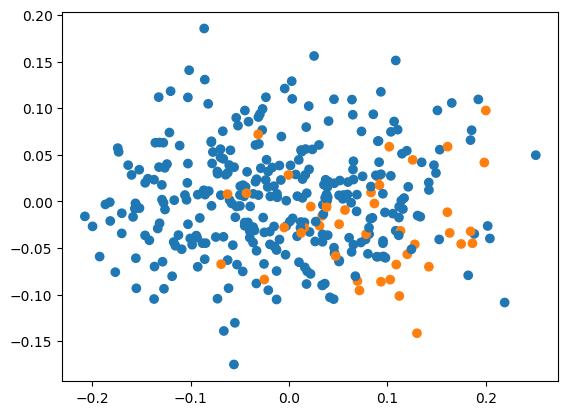

In [58]:
pca = PCA(n_components=2) #finding the two best PCs
pca.fit(X_train)
nX_train=pca.transform(X_train)
nX_test=pca.transform(X_test)
colors=np.array(["tab:blue", "tab:orange"])[y_train]
plt.scatter(nX_train[:,0], nX_train[:,1], c=colors)
plt.show()

also as a classification problem we can see it is hard to discriminate the two classes using only the two PCs

## 3. Model Tuning

For this example we are going to use Support Vector Classifiers, but any model learned so far can be used

We are going to use first [Scikit-Learn's GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), an implementation of extensive parameter search. In its basic form it just requires:
* a bare bones model constructor 
* a dictionary containing the parameters to search for. The keys of the dictionary should correspond to the parameter to test and the values to a list of possible values to test
* a scoring function defining what is the criterion to select and rank the best models
* GridSearchCV uses by default 5-Fold Cross validation, but other validation criteria can be used

The result of GridSearchCV is a structure that contains the fitted models that can then be used for learning and application

Tet's try it with the C and gamma values for support vector classification

In [59]:
from time import time
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats

#make the dictionary with the testing parameters
#gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
#Cs = [1, 10, 100, 1e3, 1e4, 1e5]
#param_grid = {'gamma': gammas, 'C': Cs}
depths = [3, 5, 10, 15]
m_sampl_split = [2, 5, 9]
prune_a = [0.0, 0.0001, 0.001, 0.01]
param_grid = {'max_depth': depths, 'min_samples_split': m_sampl_split, 'ccp_alpha': prune_a}

#define the model and do the grid search
#clf = SVC() # RBF (Gaussian) by default
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23)
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1")

start = time()
gs=gs.fit(X_train, y_train)
print(
    'GridSearchCV took %.2f seconds for %d candidate parameter settings.'
    % ((time() - start), len(gs.cv_results_['params']))
)

GridSearchCV took 1.93 seconds for 48 candidate parameter settings.


Let's identify the best element parameters [best according to the scoring function, in this case it is the F1 score]

In [60]:
#print('best gamma: %7.4f' % gs.best_estimator_.gamma)
#print('best C: %3.2f' %  gs.best_estimator_.C)
print('best maximum depth: %2.0f' % gs.best_estimator_.max_depth)
print('best minimum samples to split a node: %2.0f' %  gs.best_estimator_.min_samples_split)
print('best minimal cost pruning parameter: %1.4f' % gs.best_estimator_.ccp_alpha)

best maximum depth: 10
best minimum samples to split a node:  5
best minimal cost pruning parameter: 0.0000


Just for sake of completion, we can use the best estimator model (the one with the optimized parameters) for prediction on the test set.

In [61]:
preds=gs.best_estimator_.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', gs.best_estimator_.get_n_leaves())

F1 :  0.4000
number of leaves: 28


GridSearchCV gives you a number of statistics on the tests it runs:

In [62]:
for i in gs.cv_results_.keys(): print(i)

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_ccp_alpha
param_max_depth
param_min_samples_split
params
split0_test_score
split1_test_score
split2_test_score
split3_test_score
split4_test_score
mean_test_score
std_test_score
rank_test_score


We can print the results in a nice Pandas Data Frame

In [63]:
grid_res = pd.DataFrame(gs.cv_results_)
grid_res.sort_values(by=['rank_test_score'], ascending=True, inplace=True) #sort the tested models by score
grid_res[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']] #show only mean and std of the test score

,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
34,"{'ccp_alpha': 0.001, 'max_depth': 15, 'min_sam...",1,0.374544,0.141485,0.0034,4.898235e-04
31,"{'ccp_alpha': 0.001, 'max_depth': 10, 'min_sam...",1,0.374544,0.141485,0.0040,6.324851e-04
7,"{'ccp_alpha': 0.0, 'max_depth': 10, 'min_sampl...",1,0.374544,0.141485,0.0036,4.898819e-04
22,"{'ccp_alpha': 0.0001, 'max_depth': 15, 'min_sa...",1,0.374544,0.141485,0.0038,3.999949e-04
10,"{'ccp_alpha': 0.0, 'max_depth': 15, 'min_sampl...",1,0.374544,0.141485,0.0038,4.000426e-04
19,"{'ccp_alpha': 0.0001, 'max_depth': 10, 'min_sa...",1,0.374544,0.141485,0.0038,4.000426e-04
43,"{'ccp_alpha': 0.01, 'max_depth': 10, 'min_samp...",7,0.335819,0.172793,0.0042,1.166253e-03
46,"{'ccp_alpha': 0.01, 'max_depth': 15, 'min_samp...",7,0.335819,0.172793,0.0036,4.899014e-04
23,"{'ccp_alpha': 0.0001, 'max_depth': 15, 'min_sa...",9,0.324655,0.153176,0.0032,4.000664e-04
44,"{'ccp_alpha': 0.01, 'max_depth': 10, 'min_samp...",9,0.324655,0.153176,0.0036,4.898430e-04


we can check if the 2nd best model produces different results 

In [64]:
print('max_depth:', grid_res.loc[1, 'param_max_depth'],
      'min_samples_split:', grid_res.loc[1, 'param_min_samples_split'],
      'ccp_alpha:', '{:.2e}'.format(grid_res.loc[1, 'param_ccp_alpha']))
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23,
                             max_depth=grid_res.loc[1, 'param_max_depth'],
                             min_samples_split=grid_res.loc[1, 'param_min_samples_split'],
                             ccp_alpha=grid_res.loc[1, 'param_ccp_alpha'])
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', clf.get_n_leaves())

max_depth: 3 min_samples_split: 5 ccp_alpha: 0.00e+00
F1 :  0.0870
number of leaves: 8


Let's try now the RandomizedSearchCV and compare to the previous one.

In [65]:
# configure randomized search (by default also 5-fold CV)
# notice the loguniform distributions

param_dist = {
#    'C': stats.loguniform(1, 1e5),
#    'gamma': stats.loguniform(1e-7, 1e-1),
    'max_depth': stats.randint(3, 16),
    'min_samples_split': stats.randint(2, 10),
    'ccp_alpha': stats.loguniform(1e-5, 0.01)
}

n_iter_search = 15
rs = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
rs = rs.fit(X_train, y_train)
print(
    'RandomizedSearchCV took %.2f seconds for %d candidates parameter settings'
    % ((time() - start), n_iter_search)
)

RandomizedSearchCV took 0.44 seconds for 15 candidates parameter settings


In [66]:
print('best maximum depth: %2.0f' % rs.best_estimator_.max_depth)
print('best minimum samples to split a node: %2.0f' %  rs.best_estimator_.min_samples_split)
print('best minimal cost pruning parameter: %1.4f' % rs.best_estimator_.ccp_alpha)

best maximum depth:  3
best minimum samples to split a node:  6
best minimal cost pruning parameter: 0.0001


Now we can use the best estimator model (the one with the optimized parameters) for prediction

In [67]:
rs1 = rs.best_estimator_
rs1.fit(X_train, y_train)
preds=rs1.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', rs1.get_n_leaves())

F1 :  0.0870
number of leaves: 8


In [68]:
rand_res = pd.DataFrame(rs.cv_results_)
rand_res.sort_values(by=['rank_test_score'], ascending= True, inplace=True) #sort the tested models by score
rand_res[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']] #show only mean and std of the test score

,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
3,"{'ccp_alpha': 7.140440639788204e-05, 'max_dept...",1,0.864024,0.019087,0.0036,4.899598e-04
12,"{'ccp_alpha': 4.36688170647941e-05, 'max_depth...",1,0.864024,0.019087,0.0040,1.095409e-03
1,"{'ccp_alpha': 0.00043075129730316163, 'max_dep...",3,0.849698,0.032562,0.0032,3.999710e-04
4,"{'ccp_alpha': 0.00785165011018155, 'max_depth'...",3,0.849698,0.032562,0.0034,4.899208e-04
5,"{'ccp_alpha': 0.003850587947074165, 'max_depth...",5,0.844185,0.035935,0.0036,4.899403e-04
6,"{'ccp_alpha': 0.004394418907027441, 'max_depth...",6,0.844064,0.035205,0.0036,4.899014e-04
11,"{'ccp_alpha': 0.00015447797497839653, 'max_dep...",6,0.844064,0.035205,0.0032,3.999710e-04
10,"{'ccp_alpha': 7.434988033496029e-05, 'max_dept...",8,0.841207,0.041866,0.0036,4.898430e-04
2,"{'ccp_alpha': 0.00040223653172744115, 'max_dep...",9,0.838471,0.042797,0.0038,3.999710e-04
8,"{'ccp_alpha': 1.8646239566416107e-05, 'max_dep...",10,0.835694,0.030552,0.0036,4.898235e-04


checking the 2nd best model 

In [69]:
print('max_depth:', rand_res['param_max_depth'].iat[1],
      ', min_samples_split:', rand_res['param_min_samples_split'].iat[1],
      ', ccp_alpha:', '{:.2e}'.format(rand_res['param_ccp_alpha'].iat[1]))
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23,
                             max_depth=rand_res['param_max_depth'].iat[1],
                             min_samples_split=rand_res['param_min_samples_split'].iat[1],
                             ccp_alpha=rand_res['param_ccp_alpha'].iat[1])
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', clf.get_n_leaves())


max_depth: 3 , min_samples_split: 3 , ccp_alpha: 4.37e-05
F1 :  0.0870
number of leaves: 8


### Exercise 4
1. Discuss the values above in terms of coherency of the parameters found. Do you find a pattern in the best values for max_dept and ccp_alpha?
2. Compare the first 3 models results using the testing set and discuss your findings [Optional]


In [ ]:
# Exercise 4.1
#Enquanto que o valor para o max_dept parece ser consistentemente 3, o valor para ccp_aplpha vaira bastante


In [ ]:
# Exercise 4.2



In [ ]:
# Comments on results of Exercise 4.2

